# Correct pressure offset between pressure sensors

Inspired from Geomar code

First we need to find out when we are at the surface - argos_on,gps_reading, 

There are two pressure sensors: m_pressure is the glider pressure sensor, sci_water_pressure is the science pressure sensor

Where there is a good gps reading, find the median pressure, this is the offset 

Not every dive surfaced, so apply this offset forwards until the next gps reading

In [249]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [308]:
# load timeseries data
ds=xr.open_dataset('L0-timeseries/wam_sbus_test2.nc')

In [309]:
def calculate_ds_pressure_offset(ds):
    """
    Applies pressure offset correction to an Xarray Dataset.
    Assumes dimensions are along 'time'.
    Assumes pressure is in dbar
    Uses science pressure sensor

    Returns:sci_pressure_corrected
    """

    # 1. First intepolate pressure sensor over nans
    ds['pressure']=ds.pressure.interpolate_na(dim='time')
    # also seems like profile index needs interpolating, use ffill (TODO:see if this is an issue)
    ds['profile_index']=ds.profile_index.ffill(dim='time')
    
    # 2. Identify pressure values only when GPS is valid (m_gps_status == 0), ensure that pressure is near the surface (<1)
    # This creates a sparse array where underwater values are NaN
    surface_pressure = ds.pressure.where((ds.m_gps_status == 0)&(ds.pressure<=1))

    # 3. Group by profile index and take the median
    surface_pressure_median=surface_pressure.groupby(ds.profile_index).median()

    # 4 ffill between dive/climb pairs
    ds['pressure_offset']=xr.DataArray(surface_pressure_median.sel(profile_index=ds.profile_index).ffill(dim='time').fillna(0.0).values,dims='time')
    # 5. Create the corrected variable
    ds['sci_pressure_corrected'] = ds.pressure - ds.pressure_offset

    # Add metadata for CF-compliance
    ds.sci_pressure_corrected.attrs['units'] = 'dbar'
    ds.sci_pressure_corrected.attrs['comment'] = 'Calculated by subtracting surface drift'
    
    return ds

In [310]:
ds=calculate_ds_pressure_offset(ds)

Text(0, 0.5, 'good gps reading')

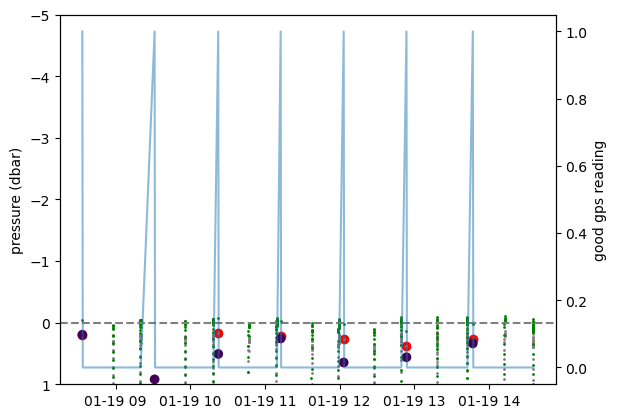

In [311]:
#visualise offset

plt.scatter(ds.time[ds.m_gps_status==0],ds.pressure[ds.m_gps_status==0],c='red')
plt.scatter(ds.time,ds.pressure,s=1,c='grey')

plt.scatter(ds.time[ds.m_gps_status==0],ds.m_pressure[ds.m_gps_status==0],c=ds.m_gps_status[ds.m_gps_status==0])
plt.scatter(ds.time,ds.sci_pressure_corrected,s=1,c='green')

plt.ylim(1,-5)
plt.ylabel('pressure (dbar)')
plt.axhline(0,c='grey',ls='--')
plt.twinx()
plt.plot(ds.time,ds.m_gps_status==0,alpha=0.5)
plt.ylabel('good gps reading')
# plt.scatter(ds.time[ds.m_argos_on>0],ds.pressure[ds.m_argos_on>0],c=ds.m_gps_status[ds.m_argos_on>0])

